In [1]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
from friend_groups import *
from modeling import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product

This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1480308849.log


SETTING UP DATA FOR PREDICTION

In [2]:
client = MongoClient("mongodb://35.163.255.3") #bigCruncher

In [3]:
allComms = collectAllComms(client)

Checking database 'goodreads_explore_from_book_tnc'
Database has 0 comms (we now have 0 in total)

Checking database 'goodreads_explore_from_book_ender'
Database has 11 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_fault_in_our_stars'
Database has 0 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_hedgehog'
Database has 2 comms (we now have 13 in total)

Checking database 'goodreads_explore_from_book_pride_and_prejudice'
Database has 9 comms (we now have 22 in total)

Checking database 'goodreads_explore_from_book_mice_and_men'
Database has 11 comms (we now have 33 in total)

Checking database 'goodreads_explore_from_book_jest'
Database has 19 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_swiftly'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_lies'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_boo

In [4]:
dbFull = client['goodreads_full']

ratingsFull = dbFull['ratings']
friendsFull = dbFull['friends']
booksFull = dbFull['books']

#updateCommsOfRaters2(booksFull, allComms)
#updateCommsOfRaters(ratingsFull, booksFull, allComms)
booksToRaterComms = getCommsOfRaters(ratingsFull, allComms)

In [5]:
glRatings = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20)

In [7]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [8]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByUser = pd.Series(numRatingsByUser)
(numRatingsByUser >= 20).mean()

0.69974554707379133

In [9]:
numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByBook = pd.Series(numRatingsByBook)
(numRatingsByBook >= 20).mean()

0.77953348382242282

PREDICTION

TRADITIONAL RECOMMENDER

In [ ]:
# make sure we train the recommender without community information

glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [ ]:
degreesOfFreedomStats(glRatingsTrain)

In [ ]:

models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [2, 4, 8],
                                                      'max_iterations': 2000,
                                                      'regularization': [1e-3, 1e-4, 1e-5],
                                                      'linear_regularization': 1e-4
                                                      })
'''
models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0,
                                                      'max_iterations': 2000,
                                                      'regularization': 1e-3,
                                                      'linear_regularization': [10**i for i in range(-4,0)]
                                                      })
'''

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-00-01-3700000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-00-01-3700000' scheduled.


In [12]:
models.get_status()
#models.get_results().sort('validation_rmse')

NameError: name 'models' is not defined

In [ ]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 15583 observations with 533 users and 170 items.

Data prepared in: 0.129172s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15583 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.71724           | 0.743847                                 |

| 1       | 2.35862           | 0.744571                                 |

| 2       | 1.17931           | 0.743249                                 |

| 3       | 0.589655          | 0.74414                                  |

| 4       | 0.294828          | 0.74324                                  |

In [17]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.9148195693401144

In [169]:
rec_engine = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 15583 observations with 533 users and 170 items.

Data prepared in: 0.191837s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15583 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.71724           | Not Viable                               |

| 1       | 1.17931           | Not Viable                               |

| 2       | 0.294828          | 0.796251                                 |

| 3       | 0.147414          | 0.78141                                  |

| 4       | 0.0737069         | 0.753429                                 |

| 5       | 0.0368535         | 0.774844                                 |

| 6       | 0.0184267         | 0.820722                                 |

| 7       | 0.00921337        | 0.874716                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0737069         | 0.753429                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 0.970063          | 0.984918              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 2.27s        | 0.88205           | 0.93093               | 0.0737069   |

| 2       | 4.65s        | 0.807362          | 0.886633              | 0.0737069   |

| 3       | 6.63s        | 0.791192          | 0.877292              | 0.0737069   |

| 4       | 9.17s        | 0.783368          | 0.872669              | 0.0737069   |

| 5       | 11.20s       | 0.778684          | 0.870188              | 0.0737069   |

| 6       | 13.62s       | 0.775246          | 0.86833               | 0.0737069   |

| 7       | 16.16s       | 0.772468          | 0.866819              | 0.0737069   |

| 8       | 18.39s       | 0.770544          | 0.865724              | 0.0737069   |

| 9       | 19.59s       | 0.76916           | 0.865022              | 0.0737069   |

| 10      | 21.82s       | 0.767356          | 0.864094              | 0.0737069   |

| 11      | 24.12s       | 0.766127          | 0.863373              | 0.0737069   |

| 12      | 26.00s       | 0.764968          | 0.862657              | 0.0737069   |

| 13      | 27.97s       | 0.763948          | 0.862011              | 0.0737069   |

| 14      | 29.10s       | 0.763026          | 0.861429              | 0.0737069   |

| 15      | 31.36s       | 0.762612          | 0.861111              | 0.0737069   |

| 16      | 33.53s       | 0.761803          | 0.860549              | 0.0737069   |

| 17      | 35.70s       | 0.761029          | 0.859947              | 0.0737069   |

| 18      | 38.06s       | 0.760482          | 0.859461              | 0.0737069   |

| 19      | 40.40s       | 0.759806          | 0.858808              | 0.0737069   |

| 20      | 42.52s       | 0.759211          | 0.858278              | 0.0737069   |

| 21      | 44.23s       | 0.758633          | 0.857684              | 0.0737069   |

| 22      | 46.15s       | 0.758186          | 0.857185              | 0.0737069   |

| 23      | 47.93s       | 0.757572          | 0.856518              | 0.0737069   |

| 24      | 49.88s       | 0.756972          | 0.855791              | 0.0737069   |

| 25      | 51.70s       | 0.75647           | 0.855072              | 0.0737069   |

| 26      | 53.51s       | 0.756026          | 0.854385              | 0.0737069   |

| 27      | 55.39s       | 0.75577           | 0.853772              | 0.0737069   |

| 28      | 57.83s       | 0.755105          | 0.852829              | 0.0737069   |

| 29      | 1m 0s        | 0.754706          | 0.852095              | 0.0737069   |

| 30      | 1m 1s        | 0.754209          | 0.851236              | 0.0737069   |

| 31      | 1m 3s        | 0.753534          | 0.850227              | 0.0737069   |

| 32      | 1m 6s        | 0.753222          | 0.849371              | 0.0737069   |

| 33      | 1m 8s        | 0.752791          | 0.848451              | 0.0737069   |

| 34      | 1m 8s        | 0.752194          | 0.847378              | 0.0737069   |

| 35      | 1m 11s       | 0.751647          | 0.846308              | 0.0737069   |

| 36      | 1m 13s       | 0.751649          | 0.845499              | 0.0737069   |

| 37      | 1m 15s       | 0.751146          | 0.844389              | 0.0737069   |

| 38      | 1m 17s       | 0.750681          | 0.843296              | 0.0737069   |

| 39      | 1m 17s       | 0.750384          | 0.842297              | 0.0737069   |

| 40      | 1m 19s       | 0.750317          | 0.841418              | 0.0737069   |

| 41      | 1m 22s       | 0.749997          | 0.84038               | 0.0737069   |

| 42      | 1m 23s       | 0.749786          | 0.839378              | 0.0737069   |

| 43      | 1m 25s       | 0.749455          | 0.838318              | 0.0737069   |

| 44      | 1m 27s       | 0.74923           | 0.837288              | 0.0737069   |

| 45      | 1m 29s       | 0.749239          | 0.836468              | 0.0737069   |

| 46      | 1m 31s       | 0.749028          | 0.835535              | 0.0737069   |

| 47      | 1m 33s       | 0.748766          | 0.834596              | 0.0737069   |

| 48      | 1m 35s       | 0.748793          | 0.833765              | 0.0737069   |

| 49      | 1m 37s       | 0.748744          | 0.832944              | 0.0737069   |

| 50      | 1m 39s       | 0.748856          | 0.832265              | 0.0737069   |

| 51      | 1m 40s       | 0.748906          | 0.831578              | 0.0737069   |

| 52      | 1m 42s       | 0.748575          | 0.830639              | 0.0737069   |

| 53      | 1m 44s       | 0.74857           | 0.829905              | 0.0737069   |

| 54      | 1m 46s       | 0.749002          | 0.82949               | 0.0737069   |

| 55      | 1m 47s       | 0.748593          | 0.828555              | 0.0737069   |

| 56      | 1m 49s       | 0.748764          | 0.827994              | 0.0737069   |

| 57      | 1m 51s       | 0.748826          | 0.827388              | 0.0737069   |

| 58      | 1m 53s       | 0.749078          | 0.826943              | 0.0737069   |

| 59      | 1m 55s       | 0.748907          | 0.826247              | 0.0737069   |

| 60      | 1m 57s       | 0.749019          | 0.825723              | 0.0737069   |

| 61      | 1m 58s       | 0.749262          | 0.825347              | 0.0737069   |

| 62      | 1m 59s       | 0.749145          | 0.824743              | 0.0737069   |

| 63      | 2m 1s        | 0.74935           | 0.824346              | 0.0737069   |

| 64      | 2m 4s        | 0.749325          | 0.823826              | 0.0737069   |

| 65      | 2m 6s        | 0.749335          | 0.823328              | 0.0737069   |

| 66      | 2m 7s        | 0.749736          | 0.823109              | 0.0737069   |

| 67      | 2m 9s        | 0.749563          | 0.822573              | 0.0737069   |

| 68      | 2m 11s       | 0.749725          | 0.82224               | 0.0737069   |

| 69      | 2m 14s       | 0.749854          | 0.821909              | 0.0737069   |

| 70      | 2m 15s       | 0.749862          | 0.8215                | 0.0737069   |

| 71      | 2m 17s       | 0.749923          | 0.821162              | 0.0737069   |

| 72      | 2m 20s       | 0.750081          | 0.820873              | 0.0737069   |

| 73      | 2m 20s       | 0.750156          | 0.820551              | 0.0737069   |

| 74      | 2m 22s       | 0.750125          | 0.820194              | 0.0737069   |

| 75      | 2m 24s       | 0.750199          | 0.819891              | 0.0737069   |

| 76      | 2m 26s       | 0.750273          | 0.819621              | 0.0737069   |

| 77      | 2m 28s       | 0.750806          | 0.819662              | 0.0737069   |

| 78      | 2m 30s       | 0.750502          | 0.819173              | 0.0737069   |

| 79      | 2m 32s       | 0.750566          | 0.818899              | 0.0737069   |

| 80      | 2m 34s       | 0.750411          | 0.818505              | 0.0737069   |

| 81      | 2m 36s       | 0.750788          | 0.818444              | 0.0737069   |

| 82      | 2m 38s       | 0.75049           | 0.81799               | 0.0737069   |

| 83      | 2m 38s       | 0.751084          | 0.818068              | 0.0737069   |

| 84      | 2m 40s       | 0.750815          | 0.817631              | 0.0737069   |

| 85      | 2m 43s       | 0.750891          | 0.817419              | 0.0737069   |

| 86      | 2m 45s       | 0.751075          | 0.817293              | 0.0737069   |

| 87      | 2m 47s       | 0.750849          | 0.816915              | 0.0737069   |

| 88      | 2m 49s       | 0.751206          | 0.816901              | 0.0737069   |

| 89      | 2m 50s       | 0.751193          | 0.816661              | 0.0737069   |

| 90      | 2m 52s       | 0.751272          | 0.816476              | 0.0737069   |

| 91      | 2m 54s       | 0.751532          | 0.816429              | 0.0737069   |

| 92      | 2m 57s       | 0.751245          | 0.816033              | 0.0737069   |

| 93      | 2m 58s       | 0.751412          | 0.815925              | 0.0737069   |

| 94      | 2m 59s       | 0.751389          | 0.8157                | 0.0737069   |

| 95      | 3m 2s        | 0.751815          | 0.815755              | 0.0737069   |

| 96      | 3m 4s        | 0.751383          | 0.815309              | 0.0737069   |

| 97      | 3m 6s        | 0.751704          | 0.815308              | 0.0737069   |

| 98      | 3m 8s        | 0.751827          | 0.815198              | 0.0737069   |

| 99      | 3m 8s        | 0.751674          | 0.814913              | 0.0737069   |

| 100     | 3m 9s        | 0.751728          | 0.814744              | 0.0737069   |

| 101     | 3m 12s       | 0.751897          | 0.81465               | 0.0737069   |

| 102     | 3m 14s       | 0.75205           | 0.814547              | 0.0737069   |

| 103     | 3m 16s       | 0.751943          | 0.814304              | 0.0737069   |

| 104     | 3m 17s       | 0.751928          | 0.814131              | 0.0737069   |

| 105     | 3m 19s       | 0.751931          | 0.813959              | 0.0737069   |

| 106     | 3m 22s       | 0.752145          | 0.813912              | 0.0737069   |

| 107     | 3m 24s       | 0.752156          | 0.813741              | 0.0737069   |

| 108     | 3m 26s       | 0.752084          | 0.813545              | 0.0737069   |

| 109     | 3m 28s       | 0.752494          | 0.813652              | 0.0737069   |

| 110     | 3m 30s       | 0.752298          | 0.813369              | 0.0737069   |

| 111     | 3m 31s       | 0.752303          | 0.813217              | 0.0737069   |

| 112     | 3m 33s       | 0.752178          | 0.812997              | 0.0737069   |

| 113     | 3m 35s       | 0.752304          | 0.812928              | 0.0737069   |

| 114     | 3m 38s       | 0.75248           | 0.812895              | 0.0737069   |

| 115     | 3m 40s       | 0.752615          | 0.812815              | 0.0737069   |

| 116     | 3m 42s       | 0.752497          | 0.812612              | 0.0737069   |

| 117     | 3m 44s       | 0.752735          | 0.812615              | 0.0737069   |

| 118     | 3m 46s       | 0.752665          | 0.812435              | 0.0737069   |

| 119     | 3m 49s       | 0.752514          | 0.812202              | 0.0737069   |

| 120     | 3m 52s       | 0.752654          | 0.812156              | 0.0737069   |

| 121     | 3m 52s       | 0.752717          | 0.812056              | 0.0737069   |

| 122     | 3m 52s       | 0.75268           | 0.811905              | 0.0737069   |

| 123     | 3m 54s       | 0.753156          | 0.812088              | 0.0737069   |

| 124     | 3m 56s       | 0.752792          | 0.811735              | 0.0737069   |

| 125     | 3m 58s       | 0.7528            | 0.811604              | 0.0737069   |

| 126     | 4m 0s        | 0.752908          | 0.811534              | 0.0737069   |

| 127     | 4m 2s        | 0.753251          | 0.811627              | 0.0737069   |

| 128     | 4m 4s        | 0.752827          | 0.811232              | 0.0737069   |

| 129     | 4m 6s        | 0.75294           | 0.811167              | 0.0737069   |

| 130     | 4m 8s        | 0.753121          | 0.811158              | 0.0737069   |

| 131     | 4m 10s       | 0.753062          | 0.810981              | 0.0737069   |

| 132     | 4m 12s       | 0.753161          | 0.810925              | 0.0737069   |

| 133     | 4m 15s       | 0.753239          | 0.810826              | 0.0737069   |

| 134     | 4m 17s       | 0.75339           | 0.810777              | 0.0737069   |

| 135     | 4m 19s       | 0.753149          | 0.810492              | 0.0737069   |

| 136     | 4m 22s       | 0.753399          | 0.810514              | 0.0737069   |

| 137     | 4m 24s       | 0.753427          | 0.810403              | 0.0737069   |

| 138     | 4m 26s       | 0.753452          | 0.810282              | 0.0737069   |

| 139     | 4m 28s       | 0.753442          | 0.810141              | 0.0737069   |

| 140     | 4m 30s       | 0.753611          | 0.810124              | 0.0737069   |

| 141     | 4m 30s       | 0.753517          | 0.809929              | 0.0737069   |

| 142     | 4m 32s       | 0.753601          | 0.809845              | 0.0737069   |

| 143     | 4m 35s       | 0.753531          | 0.809668              | 0.0737069   |

| 144     | 4m 35s       | 0.753951          | 0.809811              | 0.0737069   |

| 145     | 4m 37s       | 0.753806          | 0.809608              | 0.0737069   |

| 146     | 4m 37s       | 0.754011          | 0.809644              | 0.0737069   |

| 147     | 4m 39s       | 0.754219          | 0.809687              | 0.0737069   |

| 148     | 4m 40s       | 0.753965          | 0.809402              | 0.0737069   |

| 149     | 4m 42s       | 0.754258          | 0.809467              | 0.0737069   |

| 150     | 4m 43s       | 0.754009          | 0.809167              | 0.0737069   |

| 151     | 4m 44s       | 0.753989          | 0.80901               | 0.0737069   |

| 152     | 4m 47s       | 0.753903          | 0.808815              | 0.0737069   |

| 153     | 4m 48s       | 0.754114          | 0.808792              | 0.0737069   |

| 154     | 4m 49s       | 0.753941          | 0.808542              | 0.0737069   |

| 155     | 4m 51s       | 0.754351          | 0.808662              | 0.0737069   |

| 156     | 4m 53s       | 0.754184          | 0.808392              | 0.0737069   |

| 157     | 4m 55s       | 0.753979          | 0.808127              | 0.0737069   |

| 158     | 4m 56s       | 0.754206          | 0.808112              | 0.0737069   |

| 159     | 4m 58s       | 0.75422           | 0.807962              | 0.0737069   |

| 160     | 5m 0s        | 0.754374          | 0.807904              | 0.0737069   |

| 161     | 5m 2s        | 0.754329          | 0.807733              | 0.0737069   |

| 162     | 5m 4s        | 0.754316          | 0.807573              | 0.0737069   |

| 163     | 5m 6s        | 0.754564          | 0.807559              | 0.0737069   |

[ERROR] graphlab.toolkits._main: Toolkit error: Cancelled by user.


ToolkitError: Cancelled by user.

In [ ]:
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

In [ ]:
0.897972073875
-0.0168723871177

SOCIAL MODELS

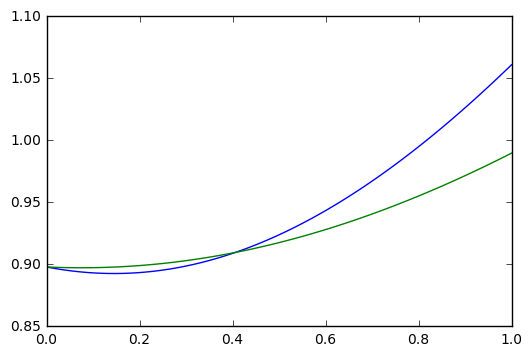

In [301]:
meanWeights = np.linspace(0,1,100)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS
'''
rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8 \
                          commMeans_rec_engine_baseline, True, False, True, weight)[1])
'''
plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
#plt.plot(meanWeights, rmsesFac, '-')

USING COMMUNITY MEANS OF RECOMMENDER PREDICTIONS

In [310]:
test = [(bookID, userID) for bookID, userID in product(glRatings['bookID'].unique(), glRatings['userID'].unique())]

In [311]:
#test
testDict = {}
npTest = np.array(test)
testDict['bookID'] = npTest[:,0]
testDict['userID'] = npTest[:,1]
sfTest = gl.SFrame(testDict)

In [312]:
allPreds = rec_engine.predict(sfTest)

In [313]:
sfTest.add_column(allPreds, 'preds')

bookID,userID,preds
1934,32119,4.0474225383
1934,271433,4.0474225383
1934,9169100,4.0474225383
1934,94664,4.0474225383
1934,177,4.0474225383
1934,8940,4.0474225383
1934,20696854,4.0474225383
1934,47585,4.0474225383
1934,9069989,4.0474225383
1934,36208,4.0474225383


In [316]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

sfTest.add_column(sfTest['userID'].apply(lambda x: commDict[int(x)]), 'comm')

bookID,userID,preds,comm
1934,32119,4.0474225383,8
1934,271433,4.0474225383,55
1934,9169100,4.0474225383,68
1934,94664,4.0474225383,30
1934,177,4.0474225383,31
1934,8940,4.0474225383,33
1934,20696854,4.0474225383,68
1934,47585,4.0474225383,73
1934,9069989,4.0474225383,48
1934,36208,4.0474225383,41


In [317]:
sfTest[['bookID', 'preds', 'comm']].groupby(['bookID', 'comm'], {'avgPreds': gl.aggregate.AVG('preds')})

bookID,comm,avgPreds
485894,49,3.94050595422
4407,30,4.00764683892
6334,49,3.59827108194
2429135,46,3.67751244714
2612,70,3.45247251798
4953,23,3.530410419
6149,2,3.84561092292
136251,59,4.23558766653
13497,58,3.72413637747
2122,60,3.81340293099


In [318]:
factorCommBookMeansTrain = {}
for row in sfTest:
    factorCommBookMeansTrain[(row['bookID'], row['comm'])] = row['preds']


In [124]:
mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, \
                          True, True, 0.5)[1]

0.93128156655103222

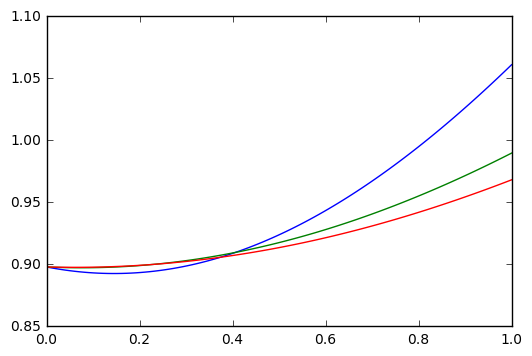

In [320]:
meanWeights = np.linspace(0,1,100)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS

rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine, \
                          True, False, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [321]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

0.141414141414
0.892687968099


FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA

In [21]:
glCommTrain = glRatingsTrainWithComm.copy()['bookID', 'comm', 'rating']
glCommTest = glRatingsTestWithComm.copy()['bookID', 'comm', 'rating']

In [22]:
glCommTrain

bookID,comm,rating
5113,30,1
18490,30,4
10799,30,5
1885,30,3
16902,30,4
6288,30,4
49552,30,3
70401,30,4
4671,30,5
4981,30,4


In [23]:
degreesOfFreedomStats(glCommTrain)

15583 observations
70 users
170 books

A recommender with 0 factor(s) (plus linear terms) would use 1.5% of the degrees of freedom present in the data.
(64.9 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 3.1% of the degrees of freedom present in the data.
(32.5 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 4.6% of the degrees of freedom present in the data.
(21.6 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 6.2% of the degrees of freedom present in the data.
(16.2 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 7.7% of the degrees of freedom present in the data.
(13.0 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 9.2% of the degrees of freedom present in the data.
(10.8 observations per model degree of

In [24]:
rec_engine_comm_baseline = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 15583 observations with 70 users and 170 items.

Data prepared in: 0.091261s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15583 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.71724           | 0.866694                                 |

| 1       | 2.35862           | 0.872708                                 |

| 2       | 1.17931           | 0.866747                                 |

| 3       | 0.589655          | 0.871322                                 |

+---------+-------------------+------------------------------------------+

| Final   | 4.71724           | 0.866694                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 0.969999          | 0.984885              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 571.086ms    | DIVERGED          | DIVERGED              | 4.71724     |

| RESET   | 573.134ms    | 0.970022          | 0.984897              |             |

| 1       | 1.16s        | DIVERGED          | DIVERGED              | 2.35862     |

| RESET   | 1.20s        | 0.970021          | 0.984896              |             |

| 1       | 1.83s        | DIVERGED          | DIVERGED              | 1.17931     |

| RESET   | 1.87s        | 0.97002           | 0.984896              |             |

| 1       | 2.46s        | DIVERGED          | DIVERGED              | 0.589655    |

| RESET   | 2.50s        | 0.970037          | 0.984904              |             |

| 1       | 3.01s        | 1.66112           | 1.28381               | 0.294828    |

| 2       | 3.56s        | 0.97813           | 0.987503              | 0.0527014   |

| 3       | 4.11s        | 0.912344          | 0.954002              | 0.028937    |

| 4       | 4.68s        | 0.891384          | 0.943054              | 0.0196918   |

| 5       | 4.69s        | 0.884748          | 0.939437              | 0.0150681   |

| 6       | 5.23s        | 0.878646          | 0.93623               | 0.0122028   |

| 11      | 7.98s        | 0.865669          | 0.929322              | 0.00625533  |

| 16      | 10.73s       | 0.861585          | 0.927135              | 0.00420559  |

| 21      | 13.43s       | 0.859697          | 0.926126              | 0.00316763  |

| 26      | 16.15s       | 0.858092          | 0.925257              | 0.0025406   |

| 31      | 18.91s       | 0.856991          | 0.924669              | 0.00210849  |

| 36      | 21.65s       | 0.856379          | 0.924338              | 0.00180181  |

| 41      | 24.39s       | 0.855829          | 0.92403               | 0.00157548  |

| 46      | 27.24s       | 0.855332          | 0.923767              | 0.00139899  |

| 51      | 30.00s       | 0.854877          | 0.923523              | 0.00124026  |

| 56      | 32.28s       | 0.85429           | 0.923207              | 0.00107045  |

| 61      | 35.00s       | 0.853321          | 0.92268               | 0.000709894 |

| 66      | 37.79s       | 0.852379          | 0.92217               | 0.000397888 |

| 71      | 40.49s       | 0.851929          | 0.921926              | 0.000266354 |

| 76      | 43.20s       | 0.851767          | 0.921839              | 0.000212831 |

| 81      | 46.01s       | 0.85147           | 0.921678              | 0.000120645 |

| 86      | 48.74s       | 0.851295          | 0.921582              | 6.85847e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.851064

Final training RMSE: 0.921457

In [25]:
rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.9540824362433775

In [26]:
rec_engine_comm = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-6,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 15583 observations with 70 users and 170 items.

Data prepared in: 0.074922s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15583 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.892803                                 |

| 5       | 0.0488281         | 0.862522                                 |

| 6       | 0.0244141         | 0.853701                                 |

| 7       | 0.012207          | 0.852796                                 |

| 8       | 0.00610352        | 0.854596                                 |

| 9       | 0.00305176        | 0.865718                                 |

| 10      | 0.00152588        | 0.886116                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.012207          | 0.852796                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 0.969999          | 0.984885              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 573.544ms    | 0.90091           | 0.948446              | 0.012207    |

| 2       | 1.10s        | 0.870904          | 0.932399              | 0.00725834  |

| 3       | 1.65s        | 0.865631          | 0.929478              | 0.00535512  |

| 4       | 2.21s        | 0.863515          | 0.928315              | 0.00431584  |

| 5       | 2.85s        | 0.86155           | 0.927233              | 0.00365075  |

| 6       | 3.36s        | 0.860073          | 0.926438              | 0.00318417  |

| 10      | 5.52s        | 0.857406          | 0.924968              | 0.00217075  |

| 11      | 6.06s        | 0.857071          | 0.924785              | 0.002021    |

| 15      | 8.17s        | 0.855782          | 0.924074              | 0.00160155  |

| 20      | 10.87s       | 0.854974          | 0.923629              | 0.00129074  |

| 25      | 13.01s       | 0.853495          | 0.922823              | 0.00077204  |

| 30      | 15.66s       | 0.852642          | 0.922356              | 0.000566235 |

| 35      | 18.30s       | 0.851729          | 0.921859              | 0.000299926 |

| 40      | 20.41s       | 0.851476          | 0.92172               | 0.000271344 |

| 45      | 23.08s       | 0.851257          | 0.921601              | 0.000248402 |

| 50      | 25.81s       | 0.851011          | 0.921466              | 0.000229529 |

| 51      | 26.37s       | 0.850961          | 0.921438              | 0.000226145 |

| 55      | 27.98s       | 0.850724          | 0.921309              | 0.000213694 |

| 60      | 30.71s       | 0.850422          | 0.921144              | 0.000200194 |

| 65      | 33.42s       | 0.850079          | 0.920957              | 0.00018853  |

| 70      | 36.16s       | 0.849705          | 0.920753              | 0.000178337 |

| 75      | 38.77s       | 0.849304          | 0.920535              | 0.000169344 |

| 80      | 41.39s       | 0.848867          | 0.920296              | 0.000161342 |

| 85      | 44.01s       | 0.848409          | 0.920046              | 0.00015417  |

| 90      | 46.65s       | 0.847922          | 0.919781              | 0.000147701 |

| 95      | 49.36s       | 0.847409          | 0.919501              | 0.000141831 |

| 100     | 52.08s       | 0.846888          | 0.919216              | 0.000136479 |

| 101     | 52.63s       | 0.846779          | 0.919157              | 0.000135464 |

| 105     | 54.81s       | 0.84635           | 0.918923              | 0.000131575 |

| 110     | 57.49s       | 0.84581           | 0.918628              | 0.000127063 |

| 115     | 1m 0s        | 0.845267          | 0.918332              | 0.000122897 |

| 120     | 1m 2s        | 0.844733          | 0.91804               | 0.000119036 |

| 125     | 1m 5s        | 0.844204          | 0.917751              | 0.000115447 |

| 130     | 1m 7s        | 0.843697          | 0.917474              | 0.0001121   |

| 135     | 1m 10s       | 0.843199          | 0.917201              | 0.000108972 |

| 140     | 1m 13s       | 0.842713          | 0.916935              | 0.00010604  |

| 145     | 1m 15s       | 0.842248          | 0.91668               | 0.000103285 |

| 150     | 1m 18s       | 0.841808          | 0.916439              | 0.000100692 |

| 155     | 1m 21s       | 0.841385          | 0.916208              | 9.82463e-05 |

| 160     | 1m 23s       | 0.840991          | 0.915991              | 9.59346e-05 |

| 165     | 1m 25s       | 0.84061           | 0.915783              | 9.37459e-05 |

| 170     | 1m 28s       | 0.84025           | 0.915585              | 9.16702e-05 |

| 175     | 1m 31s       | 0.839908          | 0.915397              | 8.96988e-05 |

| 180     | 1m 33s       | 0.839588          | 0.915222              | 8.78235e-05 |

| 185     | 1m 36s       | 0.839283          | 0.915054              | 8.60372e-05 |

| 190     | 1m 38s       | 0.838994          | 0.914896              | 8.43334e-05 |

| 195     | 1m 41s       | 0.838719          | 0.914745              | 8.27064e-05 |

| 200     | 1m 44s       | 0.838458          | 0.914601              | 8.11508e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.838134

Final training RMSE: 0.914424

In [27]:
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall']
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall'] - rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.949743551074
-0.00433888516916


In [ ]:
0.949743551074
-0.00433888516916
In [ ]:
In [ ]:


In [28]:
mixedPred(glRatingsTestWithComm, \
          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
          False, True, True, 0)[1]

0.89795159351865173

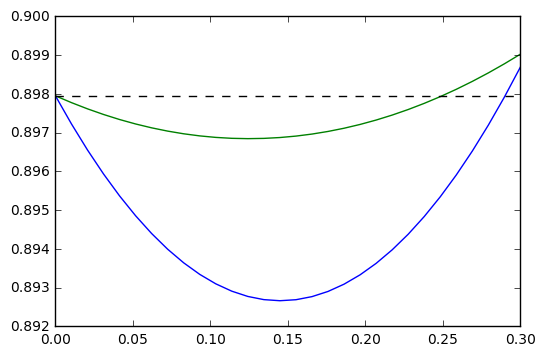

In [121]:
meanWeights = np.linspace(0,0.3,30)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA
rmsesSocialRec = []

for weight in meanWeights:
    rmsesSocialRec.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, True, weight)[1])


plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSocialRec, '-');
plt.axhline(rmsesSimple[0],color='k',linestyle='--');

In [32]:
'''
models = gl.toolkits.model_parameter_search.grid_search.create((glCommTrain, glCommTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'comm',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [4, 8, 16, 32],
                                                      'max_iterations': 1000,
                                                      'regularization': [1e-5, 1e-6, 1e-7, 1e-8],
                                                      'linear_regularization': 1e-4
                                                      })
                                                      '''

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-01-39-2000000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-01-39-2000000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-28-2016-01-39-2000000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-28-2016-01-39-2000000-b0524'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-01-39-2000000-b0524' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-01-39-2000000-b0524' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-01-39-2000001' ready for execution


In [157]:
models.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 16}

In [123]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSocialRec)]
print rmsesSocialRec[np.argmin(rmsesSocialRec)]

0.144827586207
0.892663869255

0.124137931034
0.896846389937


In [124]:
bestWeightComm = meanWeights[np.argmin(rmsesSimple)]

predsComm = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, True, bestWeightComm)[0]

predsBase = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, True, 0)[0]

In [125]:
signTestFrame = glRatingsTestWithComm[['bookID','userID','comm','rating']].copy()
signTestFrame.add_column(gl.SArray(predsComm), 'predsComm')
signTestFrame.add_column(gl.SArray(predsBase), 'predsBase')

bookID,userID,comm,rating,predsComm,predsBase
394535,160216,30,5,4.02063938171,4.02719170742
9717,160216,30,3,3.74233595163,3.75515091118
7613,160216,30,4,3.74696593649,3.74645210316
2956,160216,30,2,3.86955629972,3.72044889887
6295,160216,30,3,3.75665295018,3.71849789635
19543,1,31,5,4.44285118763,4.6872050178
12296,1,31,3,3.62764927669,3.64926729935
10365,1,31,5,4.51229427253,4.42969894772
14497,1,31,4,4.30287935406,4.43885085757
48855,1,31,4,4.37227714375,4.4614213824


In [126]:
errsBase = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsBase']))
errsBase

errsComm = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsComm']))
(errsComm < errsBase).mean()

0.51576004067107273

In [127]:
roundedPredsBase = np.round(predsBase)
roundedPredsComm = np.round(predsComm)

In [128]:
(roundedPredsBase == signTestFrame['rating']).mean()

0.42348754448398579

In [129]:
(roundedPredsComm == signTestFrame['rating']).mean()

0.42069140823589224

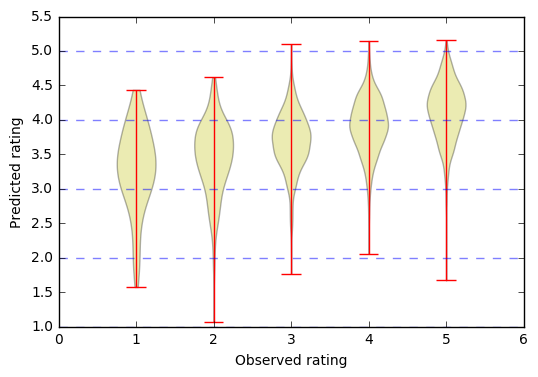

In [130]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(predsBase[np.array(glRatingsTest['rating']) == rating]))

plt.violinplot(preds_by_rating, positions=rating_cats);
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');
for rating in rating_cats:
    plt.axhline(rating,linestyle='--',linewidth=1,alpha=0.5)

In [152]:
for i, category in enumerate(preds_by_rating):
    print (i, np.mean(category))

(0, 3.2848400712211192)
(1, 3.4583918527565776)
(2, 3.6915827127897818)
(3, 3.9184163286921092)
(4, 4.1266416383023667)


(array([   96.,     0.,   276.,     0.,     0.,   847.,     0.,  1499.,
            0.,  1216.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

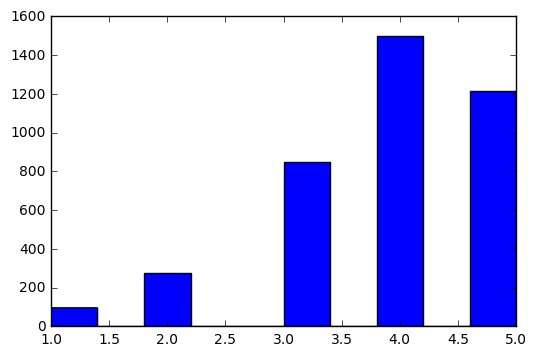

In [163]:
plt.hist(glRatingsTest['rating'])

In [164]:
coef_dict = rec_engine.get('coefficients')

In [166]:
coef_dict['userID']

userID,linear_terms,factors
160216,-0.112027734518,"[0.0097519736737,0.0252745822072, ..."
1,0.39820125699,"[-0.00699024228379,-0.0271312911063, ..."
177,-0.268160998821,"[0.00728796655312,0.0196600388736, ..."
270,-0.0685844495893,"[-0.0102906404063,-0.121005155146, ..."
4852,-0.367633551359,"[-0.006593931932,-0.0461627207696, ..."
44323,0.449285835028,"[0.00444597098976,0.0255383364856, ..."
46020,0.533422529697,"[0.00563824409619,0.019762178883, ..."
7099,0.169484212995,"[-0.00122683122754,0.0338310003281, ..."
17893,0.0107212429866,"[0.000461884250399,0.0123364524916, ..."
13136,-0.866620004177,"[0.00617108587176,0.00421393755823, ..."


In [172]:
numCommsByBook = {k: len(v) for k, v in booksToRaterComms.items() if k in glRatings['bookID']}

In [286]:
[(k, v) for k, v in numCommsByBook.items() if v == 40]

[(4473, 40),
 (6310, 40),
 (6514, 40),
 (7445, 40),
 (7588, 40),
 (1622, 40),
 (11275, 40),
 (37415, 40),
 (49041, 40),
 (62291, 40)]

In [287]:
for bID in [k for k, v in numCommsByBook.items() if v  == 40]:
    print bID
    print bookTitle(bID)

4473
(u'A Prayer for Owen Meany', 234899)
6310
(u'Charlie and the Chocolate Factory\n      \n          (Charlie Bucket #1)', 478461)
6514
(u'The Bell Jar', 416788)
7445
(u'The Glass Castle', 603127)
7588
(u'A Portrait of the Artist as a Young Man', 97488)
1622
(u"A Midsummer Night's Dream", 336536)
11275
(u'The Wind-Up Bird Chronicle\n      \n          (\u306d\u3058\u307e\u304d\u9ce5\u30af\u30ed\u30cb\u30af\u30eb #1-3)', 146490)
37415
(u'Their Eyes Were Watching God', 184857)
49041
(u'New Moon\n      \n          (Twilight  #2)', 1146697)
62291
(u'A Storm of Swords\n      \n          (A Song of Ice and Fire #3)', 488072)


In [331]:
testBID = 11275

commIndices = []
allCommBookRatings = []
numRaters = []
meanRatings = []
earliestTimes = []

for commIndex in booksToRaterComms[testBID]:
    commRatings = ratingsFull.find({'userID': {'$in': allComms[commIndex]}})
    commBookRatings = [(r['ratings'][str(testBID)][0], \
                        datetime.strptime(r['ratings'][str(testBID)][2], grDateFormat), \
                        r['userID'])\
                       for r in commRatings if str(testBID) in r['ratings'].keys()]
    allCommBookRatings.append(commBookRatings)
    
    commIndices.append(commIndex)
    numRaters.append(len(commBookRatings))
    meanRatings.append(np.mean(np.array(commBookRatings)[:,0]))
    earliestTimes.append(min(r[1] for r in commBookRatings))

timeOrder = np.argsort(earliestTimes)

numRatersCumSum = 0
for i in timeOrder:
    print 'Community %d' % commIndices[i]
    print '%d raters' % numRaters[i]
    numRatersCumSum += numRaters[i]
    print '%.1f mean rating' % meanRatings[i]
    print 'Earliest rating on %s' % datetime.strftime(earliestTimes[i], grDateFormat)
    print '\nTotal raters thus far: %d\n' % numRatersCumSum

Community 31
1 raters
4.0 mean rating
Earliest rating on Jan 08, 2007

Total raters thus far: 1

Community 50
4 raters
2.2 mean rating
Earliest rating on Feb 20, 2007

Total raters thus far: 5

Community 33
5 raters
4.0 mean rating
Earliest rating on Feb 22, 2007

Total raters thus far: 10

Community 21
1 raters
4.0 mean rating
Earliest rating on Feb 24, 2007

Total raters thus far: 11

Community 27
1 raters
5.0 mean rating
Earliest rating on Feb 27, 2007

Total raters thus far: 12

Community 20
3 raters
4.3 mean rating
Earliest rating on Mar 03, 2007

Total raters thus far: 15

Community 60
2 raters
4.0 mean rating
Earliest rating on Mar 11, 2007

Total raters thus far: 17

Community 61
1 raters
5.0 mean rating
Earliest rating on Mar 15, 2007

Total raters thus far: 18

Community 1
3 raters
4.0 mean rating
Earliest rating on Mar 16, 2007

Total raters thus far: 21

Community 66
4 raters
4.2 mean rating
Earliest rating on Mar 20, 2007

Total raters thus far: 25

Community 75
3 raters
5

In [339]:
relevantSTF = signTestFrame[signTestFrame.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantSTF

bookID,userID,comm,rating,predsComm,predsBase
11275,8864511,48,4,3.8848849856,3.80561740489
11275,8068801,48,4,4.05736732805,4.00731046663
11275,7551020,48,4,3.62097712839,3.49701547508
11275,6512932,48,4,3.83948903149,3.75253342629
11275,9136579,48,1,4.42307089795,4.43494770561
11275,19571542,48,5,4.80670836147,4.8835560299
11275,4318144,48,5,4.57200901103,4.60910920882


In [340]:
set(relevantSTF['userID']) & set(np.array(allCommBookRatings[np.argwhere(np.array(commIndices)==48)[0,0]])[:,2])

{4318144, 6512932, 7551020, 8068801, 8864511, 9136579, 19571542}

In [ ]:
set(relevantSTF['userID'])